In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd, numpy as np, gc
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

train_data = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv")

# Read in the data in chunks of approximately the same number of session ids
chunks = []
for i, chunk in enumerate(pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', chunksize=chunk_size, iterator=True)):
    chunk = chunk[chunk['session_id'].isin(train_data['session_id'].unique()[i*chunk_size:(i+1)*chunk_size])]
    chunks.append(chunk)

train_data['index'] = train_data['index'].astype('int64')
train_data['level'] = train_data['level'].astype('int16')
train_data['page'] = train_data['page'].astype('float32')
train_data['room_coor_x'] = train_data['room_coor_x'].astype('float32')
train_data['room_coor_y'] = train_data['room_coor_y'].astype('float32')
train_data['screen_coor_x'] = train_data['screen_coor_x'].astype('float32')
train_data['screen_coor_y'] = train_data['screen_coor_y'].astype('float32')
train_data['fullscreen'] = train_data['fullscreen'].astype('float32')
train_data['hq'] = train_data['hq'].astype('float32')

category = ['event_name', 'name','fqid', 'room_fqid', 'text']

numerical = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

options = ['fullscreen','hq','music']

events = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','notebook_click','map_click',
          'object_hover','observation_click','checkpoint']

names = ['undefined','basic','close','prev','next']

def feature_engineer(train):
    
    dfs = []
    for i in category:
        col = train.groupby(['session_id','level_group'])[i].agg('nunique')
        col.name = col.name + '_nunique'
        dfs.append(col)
    for i in category:
        col = train.groupby(['session_id','level_group'])[i].agg('count')
        col.name = col.name + 'Count'
        dfs.append(col)
    for i in numerical:
        col = train.groupby(['session_id','level_group'])[i].agg('mean')
        col.name = col.name + 'AVG'
        dfs.append(col)
    for i in numerical:
        col = train.groupby(['session_id','level_group'])[i].agg('std')
        col.name = col.name + 'STD'
        dfs.append(col)
    for i in options:
        col = train.groupby(['session_id','level_group'])[i].agg('count')
        col.name = col.name + 'Count'
        dfs.append(col)
    for i in names: 
        train[i] = (train.name == i).astype('int8')
    for i in names:
        col = train.groupby(['session_id','level_group'])[i].agg('sum')
        col.name = col.name + 'SUM'
        dfs.append(col)
    for i in events: 
        train[i] = (train.event_name == i).astype('int8')
    for i in events + ['elapsed_time']:
        col = train.groupby(['session_id','level_group'])[i].agg('sum')
        col.name = col.name + 'SUM'
        dfs.append(col)
    train = train.drop(events,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [2]:
category = ['event_name', 'name', 'fqid', 'room_fqid', 'text']
numerical = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
             'screen_coor_x', 'screen_coor_y', 'hover_duration']
events = ['navigate_click', 'person_click', 'cutscene_click', 'object_click',
          'map_hover', 'notification_click', 'notebook_click', 'map_click',
          'object_hover', 'observation_click', 'checkpoint']
names = ['undefined', 'basic', 'close', 'prev', 'next']
date = ["year", "month", "day", "hour", "minute", "hour_lag1", "hour_lag2",
       "minute_lag1", "minute_lag2"]
text = ["No... because history is boring!","So? History is boring!","I suppose historians are boring, too?",
            "Ugh. Meetings are so boring.","A boring old shirt.","I'm a historian, not a zookeeper!","I love these photos of me and Teddy!",
           "You look like you're on a mission."]
words = ["like", "funny", "boring","forget","nice" , "friendly","Thanks","love"]

In [3]:

def feature_engineer(train):
    dfs = []
    
    
    for i in category:
        col = train.groupby(['session_id', 'level_group'])[i].agg('nunique')
        col.name = col.name + '_nunique'
        dfs.append(col)
    
    for i in category:
        col = train.groupby(['session_id', 'level_group'])[i].agg('count')
        col.name = col.name + 'Count'
        dfs.append(col)
    
    for i in numerical:
        col = train.groupby(['session_id', 'level_group'])[i].agg('mean')
        col.name = col.name + 'AVG'
        dfs.append(col)
    
    for i in numerical:
        col = train.groupby(['session_id', 'level_group'])[i].agg('std')
        col.name = col.name + 'STD'
        dfs.append(col)
    
    for i in names:
        train[i] = (train.name == i).astype('int8')
    
    for i in names:
        col = train.groupby(['session_id', 'level_group'])[i].agg('sum')
        col.name = col.name + 'SUM'
        dfs.append(col)
    
    for i in events:
        train[i] = (train.event_name == i).astype('int8')
    
    for i in events + ['elapsed_time']:
        col = train.groupby(['session_id', 'level_group'])[i].agg('sum')
        col.name = col.name + 'SUM'
        dfs.append(col)
        
    for i in text:
        train[i] = (train.text == i).astype('int8')
    
    for i in text:
        col = train.groupby(['session_id', 'level_group'])[i].agg('count')
        col.name = col.name + 'Count'
        dfs.append(col)
        
    for i in words:
        train[i] = (train.text == i).astype('int8')
    
    for i in words:
        col = train.groupby(['session_id', 'level_group'])[i].agg('count')
        col.name = col.name + 'Count'
        dfs.append(col)
        
    for i in text:
        train[i] = (train.text == i).astype('int8')
    
    for i in text:
        col = train.groupby(['session_id', 'level_group'])[i].agg('nunique')
        col.name = col.name + '_nunique'
        dfs.append(col)
        
    for i in words:
        train[i] = (train.text == i).astype('int8')
    
    for i in words:
        col = train.groupby(['session_id', 'level_group'])[i].agg('nunique')
        col.name = col.name + '_nunique'
        dfs.append(col)
        
    train = train.drop(events, axis=1)
    
    # Extract year, month, day, hour, and minute from 'elapsed_time'
    elapsed_time = pd.to_datetime(train['elapsed_time'], unit='ms')
    train['year'] = elapsed_time.dt.year
    train['month'] = elapsed_time.dt.month
    train['day'] = elapsed_time.dt.day
    train['hour'] = elapsed_time.dt.hour
    train['minute'] = elapsed_time.dt.minute
    train['hour_lag1'] = train['hour'].shift(1)
    train['hour_lag2'] = train['hour'].shift(2)
    train['minute_lag1'] = train['minute'].shift(2)
    train['minute_lag2'] = train['minute'].shift(4)
    
    """
    for i in date :
        col = train.groupby(['session_id', 'level_group'])[i].agg('count')
        col.name = col.name + 'Count'
        dfs.append(col)
    
    for i in date :
        col = train.groupby(['session_id', 'level_group'])[i].agg('nunique')
        col.name = col.name + '_nunique'
        dfs.append(col)
    """
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

column_names = ["session_id", "index", 'elapsed_time','event_name', 'name','level','page','room_coor_x', 'room_coor_y', 
                'screen_coor_x', 'screen_coor_y', 'hover_duration','text','fqid', 'room_fqid', 'text_fqid',
               'fullscreen','hq','music','level_group']


len(column_names)

train_data = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', usecols=[0])

# Find the number of unique session ids
num_sessions = len(train_data['session_id'])

# Calculate the chunk size
chunk_size = num_sessions // 10
print(chunk_size)
# Read in the data in chunks of approximately the same number of session ids
chunks = []
for i, chunk in enumerate(pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', chunksize=chunk_size, iterator=True)):
    chunk = chunk[chunk['session_id'].isin(train_data['session_id'].unique()[i*chunk_size:(i+1)*chunk_size])]
    chunks.append(chunk)

all_train_data = []
for train in chunks:
    train = feature_engineer(train)
    all_train_data.append(train)
    
print('\n')
del train
df = pd.concat(all_train_data, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

In [4]:
# READ SESSION ID ONLY
tmp = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int(np.ceil(len(tmp) / PIECES))

reads = []
skips = [0]
for k in range(PIECES):
    a = k * CHUNK
    b = (k + 1) * CHUNK
    if b > len(tmp):
        b = len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1] + r)

print(f'To avoid memory error, we will read the data in {PIECES} pieces of sizes:')
print(reads)

# PROCESS DATA IN PIECES
all_pieces = []
print(f'Processing data as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k, ', ', end='')
    SKIPS = 0
    if k > 0:
        SKIPS = range(1, skips[k] + 1)
    data = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                       nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(data)
    all_pieces.append(df)

# CONCATENATE ALL PIECES
print('\n')
del data; gc.collect()
training = pd.concat(all_pieces, axis=0)
print('Shape of all data after feature engineering:', training.shape )
training.head()


To avoid memory error, we will read the data in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]
Processing data as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

Shape of all data after feature engineering: (70686, 76)


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,event_nameCount,nameCount,fqidCount,room_fqidCount,...,I love these photos of me and Teddy!_nunique,You look like you're on a mission._nunique,like_nunique,funny_nunique,boring_nunique,forget_nunique,nice_nunique,friendly_nunique,Thanks_nunique,love_nunique
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,56,165,165,104,165,...,2,1,1,1,1,1,1,1,1,1
20090312431273200,13-22,10,3,49,12,168,420,420,313,420,...,1,1,1,1,1,1,1,1,1,1
20090312431273200,5-12,10,3,39,11,124,296,296,235,296,...,1,1,1,1,1,1,1,1,1,1
20090312433251036,0-4,11,4,22,6,49,139,139,97,139,...,1,1,1,1,1,1,1,1,1,1
20090312433251036,13-22,11,6,73,16,183,1297,1297,762,1297,...,1,1,1,1,1,1,1,1,1,1


# Read the count of session IDs in the file
session_counts = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv", usecols=[0]).groupby('session_id').session_id.agg('count')

# Define the number of pieces to divide the file into
num_pieces = 10

# Compute the size of each piece
piece_size = int(np.ceil(len(session_counts) / num_pieces))

# Initialize variables
pieces = []
skips = [0]

# Iterate over each piece and apply feature engineering to each one
for i in range(num_pieces):
    # Compute the start and end index of the chunk
    start_idx = i * piece_size
    end_idx = min((i + 1) * piece_size, len(session_counts))
    
    # Read the chunk of data from the file
    chunk = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv", skiprows=skips[-1], nrows=end_idx-start_idx)
    
    # Apply feature engineering to the chunk
    features = feature_engineer(chunk)
    
    # Add the chunk of features to the list
    pieces.append(features)
    
    # Update the skip index for the next chunk
    skips.append(skips[-1] + session_counts.iloc[start_idx:end_idx].sum())
    
# Concatenate all the pieces into a single DataFrame
train_features = pd.concat(pieces, axis = 0)

print('\n')
del pieces
print('Shape of all train data after feature engineering:', df.train_features )
df.head()

# Apply feature engineering to the chunk
    features = feature_engineer(chunk)
    
    # Add the chunk of features to the list
    pieces.append(features)
    
    # Update the skip index for the next chunk
    skips.append(skips[-1] + session_counts.iloc[start_idx:end_idx].sum())
    
# Concatenate all the pieces into a single DataFrame
train_features = pd.concat(pieces)

training = feature_engineer(train_data)

In [7]:
training["loveCount"].tail(60)

session_id
22090622534263404     216
22090622534263404     660
22090622534263404     525
22100208551963804     155
22100208551963804     383
22100208551963804     318
22100209282577744     155
22100209282577744     592
22100209282577744     323
22100210350401024     169
22100210350401024     446
22100210350401024     307
22100211040903920     104
22100211040903920     380
22100211040903920     267
22100211215679332     191
22100211215679332     480
22100211215679332     320
22100211280762644     143
22100211280762644     379
22100211280762644     256
22100211424422756     176
22100211424422756     582
22100211424422756     350
22100212020704970     206
22100212020704970     531
22100212020704970     446
22100212552203824     277
22100212552203824    1046
22100212552203824     726
22100213081672770     131
22100213081672770     574
22100213081672770     297
22100213133089136     136
22100213133089136     424
22100213133089136     252
22100215032067016     167
22100215032067016     438
2

In [8]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )

(424116, 4)


In [9]:
targets

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [10]:
FEATURES = [c for c in training.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = training.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 75 features
We will train with 23562 users info


In [11]:
ALL_USERS[:5]

Int64Index([20090312431273200, 20090312433251036, 20090312455206810,
            20090313091715820, 20090313571836404],
           dtype='int64', name='session_id')

gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=training, groups=training.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = training.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = training.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

In [12]:
from catboost import CatBoostClassifier

gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=training, groups=training.index)):
    print('#' * 25)
    print('### Fold', i + 1)
    print('#' * 25)

    catboost_params = {
        'loss_function': 'Logloss',
        'learning_rate': 0.05,
        'depth': 4,
        'iterations': 1000,
        'early_stopping_rounds': 50,
        'subsample': 0.8,
        'colsample_bylevel': 0.4,
        'use_best_model': True
    }

    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1, 19):

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t <= 3:
            grp = '0-4'
        elif t <= 13:
            grp = '5-12'
        elif t <= 22:
            grp = '13-22'

        # TRAIN DATA
        train_x = training.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = training.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf = CatBoostClassifier(**catboost_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(f'{t}({clf.best_iteration_}), ', end='')

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t - 1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:, 1]

    print()


#########################
### Fold 1
#########################
1(267), 2(135), 3(234), 4(320), 5(273), 6(217), 7(261), 8(123), 9(260), 10(479), 11(232), 12(302), 13(371), 14(472), 15(294), 16(164), 17(255), 18(421), 
#########################
### Fold 2
#########################
1(364), 2(343), 3(234), 4(289), 5(226), 6(242), 7(270), 8(148), 9(263), 10(273), 11(307), 12(160), 13(216), 14(427), 15(367), 16(232), 17(156), 18(201), 
#########################
### Fold 3
#########################
1(315), 2(208), 3(238), 4(625), 5(288), 6(249), 7(304), 8(81), 9(261), 10(359), 11(231), 12(69), 13(264), 14(422), 15(371), 16(99), 17(282), 18(174), 
#########################
### Fold 4
#########################
1(400), 2(90), 3(84), 4(345), 5(238), 6(285), 7(400), 8(219), 9(213), 10(305), 11(246), 12(235), 13(385), 14(439), 15(324), 16(147), 17(154), 18(377), 
#########################
### Fold 5
#########################
1(358), 2(119), 3(202), 4(513), 5(442), 6(318), 7(327), 8(113), 9(221), 10

In [ ]:
models

In [13]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [ ]:
true

In [14]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

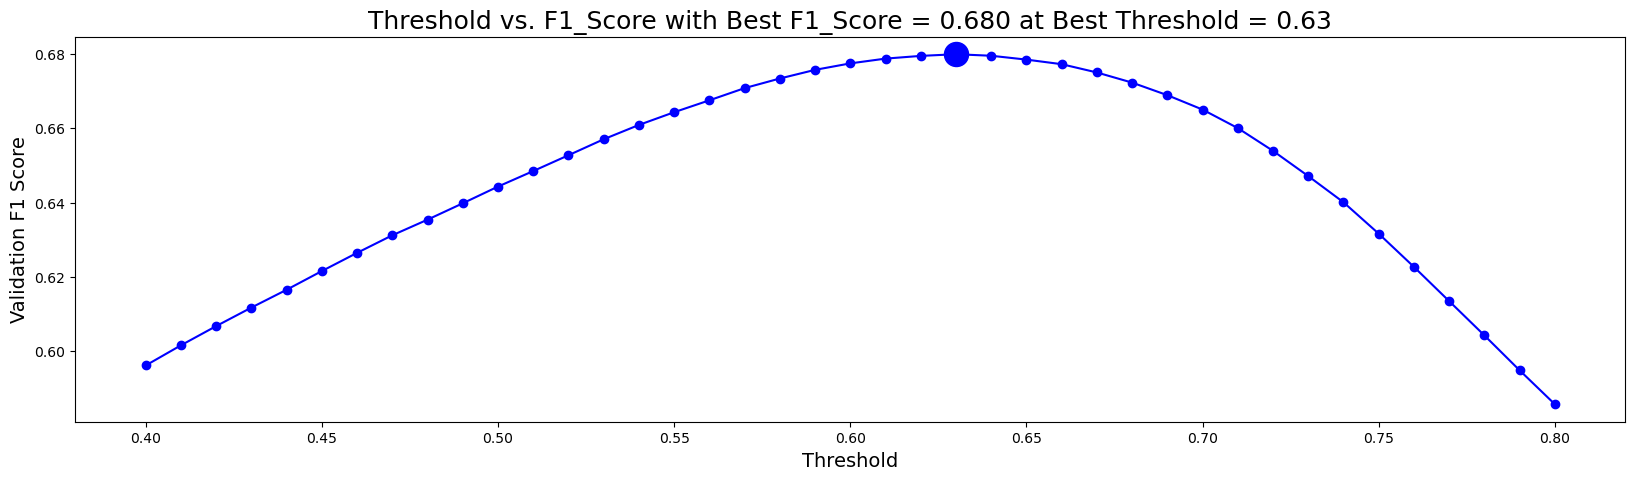

In [15]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [16]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6060920937015607
Q1: F1 = 0.49664457199750167
Q2: F1 = 0.4904479578392622
Q3: F1 = 0.6264959935685847
Q4: F1 = 0.5789675393910674
Q5: F1 = 0.6129724570628459
Q6: F1 = 0.5882991567910875
Q7: F1 = 0.539953950639283
Q8: F1 = 0.6013805275694479
Q9: F1 = 0.5252638298844697
Q10: F1 = 0.5918423169084299
Q11: F1 = 0.49595131698488293
Q12: F1 = 0.43817960846159404
Q13: F1 = 0.6112764746475084
Q14: F1 = 0.5091336134081794
Q15: F1 = 0.4619621977360646
Q16: F1 = 0.5411725506326285
Q17: F1 = 0.49147490534854477
==> Overall F1 = 0.6799868653886694


In [17]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del targets, training, oof, true
_ = gc.collect()

In [18]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[0,1]
        print(p)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > 0.69 )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
0.7481845768091147
0.9884015078134121
0.9582947824878408
0.8962506938083037
0.4868950577528898
0.7931929066164041
0.6664704514364655
0.5306699715547681
0.6817430137032641
0.43251382375007086
0.5613898553988377
0.839449647217157
0.14168815909014618
0.6886704269283869
0.43583940851843855
0.7204083101169001
0.6456402732583053
0.9329606680348245
0.6614540057480746
0.9763140127058512
0.9116959028650674
0.45409185755559084
0.31928737788393274
0.41760600149673377
0.47130458488670435
0.5041177260531544
0.42495413875727495
0.30754773655160417
0.46050802036290556
0.7300411460220417
0.11227012343024055
0.5785071337393064
0.3138573365807216
0.6732444339163381
0.60090442601606
0.9089954002805867
0.7664691754164193
0.9920319463258355
0.9477922728111733
0.8850214755048477
0.6006981422727469
0.8218719694763069
0.8006999056756571
0.6128775953378577
0.7842629878291119
0.5365250506

In [19]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,0
